In [16]:
import warnings
warnings.filterwarnings("ignore")

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [18]:
import statsmodels.tsa.stattools

In [19]:
from statsmodels.tsa.arima.model import ARIMA

### easy  
##### найти данные о заболеваемости/смертности/выздоровлении COVID-19 (они есть например на Kaggle) и использовать их для решения заданий; можно использовать как данные по какому-то конкретному региону/стране, так и данные по всему миру  
##### проверить ряд на стационарность, привести ряд к стационарному виду  
##### построить прогноз заболеваемости, используя модель ARIMA, на месяц вперед; подобрать оптимальные параметры модели; визуализировать результат. Выглядит ли такой прогноз реалистичным?  
Для решения задачи можно использовать `pmdarima`

**даннные по COVID-19, источник https://www.kaggle.com/josephassaker/covid19-global-dataset**

In [20]:
df = pd.read_csv('data/worldometer_coronavirus_daily_data.csv',index_col=0, parse_dates=True)
df.head()

,country,cumulative_total_cases,daily_new_cases,active_cases,cumulative_total_deaths,daily_new_deaths
date,,,,,,
2020-02-15,Afghanistan,0.0,NaN,0.0,0.0,NaN
2020-02-16,Afghanistan,0.0,NaN,0.0,0.0,NaN
2020-02-17,Afghanistan,0.0,NaN,0.0,0.0,NaN
2020-02-18,Afghanistan,0.0,NaN,0.0,0.0,NaN
2020-02-19,Afghanistan,0.0,NaN,0.0,0.0,NaN


отбор данных о заболеваемости в Финляндии, группировка

In [21]:
df['index'] = pd.to_datetime
df['month'] = df.index.month
df['year'] = df.index.year
df['day'] = df.index.day

df_Fin = df[(df['country'] == 'Finland')][['year','month','day','daily_new_cases']].fillna(0).groupby(['year', 'month','day']).mean()
df_Fin

#так как данные за каждый день, в группировке вместо mean с тем же результатом можно было поставить max или min

daily_new_cases
year month day                 
2020 2     15               0.0
           16               0.0
           17               0.0
           18               0.0
           19               0.0
...                         ...
2021 7     26             267.0
           27             612.0
           28             644.0
           29             765.0
           30             748.0

[532 rows x 1 columns]

<AxesSubplot:xlabel='year,month,day'>

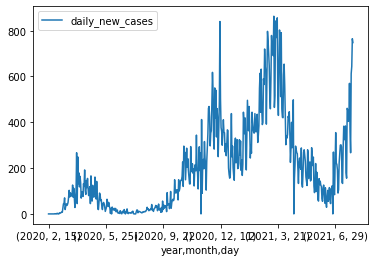

In [22]:
df_Fin.plot()

**проверка на стационарность с уровнем значимости 0,05**

критерий KPSS (Kwiatkowski–Phillips–Schmidt–Shin)  
Н0 - ряд стационарен

In [23]:
alpha = 0.05
stat, p_value, *_ = statsmodels.tsa.stattools.kpss(df_Fin.daily_new_cases)
print (stat, p_value)
if p_value < alpha:
    print('стационарен')
else:
    print('не стационарен')

1.6489988276133714 0.01
стационарен


DF-тест (Dickey — Fuller test)  
Н0 - ряд не стационарен

In [24]:
stat, pvalue, *_ = statsmodels.tsa.stattools.adfuller(df_Fin.daily_new_cases)
print (stat, p_value)
if p_value < alpha:
    print('стационарен')
else:
    print('не стационарен')

-1.7240721454737062 0.01
стационарен


**оба метода показывают, что ряд стационарен**

**прогноз заболеваемости на месяц вперед (модель ARIMA)**

подбор параметров с помощью графиков

In [26]:
from statsmodels.graphics.tsaplots import acf, pacf, plot_acf, plot_pacf

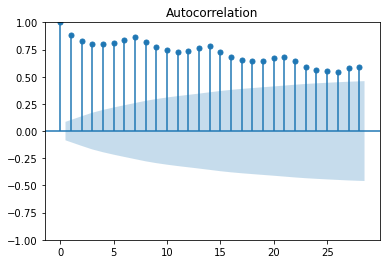

In [27]:
#параметр p
plot_acf(df_Fin).show()

p вне синей области - 0 или 1 (с натяжкой)

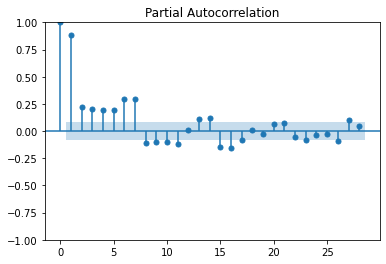

In [28]:
#параметр q
plot_pacf(df_Fin).show()

q вне синей области - также 0 или 1 (с натяжкой)

данные без обработки, p=1, q=1

AIC= 6214.72467271029


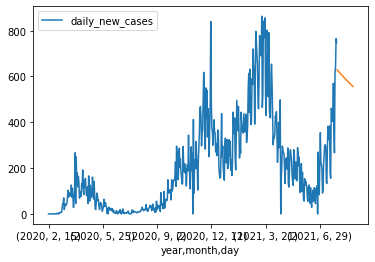

In [29]:
model_fit = ARIMA(df_Fin, order=(1, 0, 1)).fit()
df_Fin.plot()
model_fit.forecast(30).plot()
print('AIC=', model_fit.aic)

**приведение ряда к стационарному виду** (на всякий случай, т.к. оба метода и так показали, что ряд стационарен), p=1, q=1;    
так как явного тренда нет, а дисперсия не постоянная, логарифмируем ряд

In [30]:
x = df_Fin.daily_new_cases.values
x_min = abs(min(x))
x_log = np.log(x+x_min+10)

AIC= 647.9593445024182


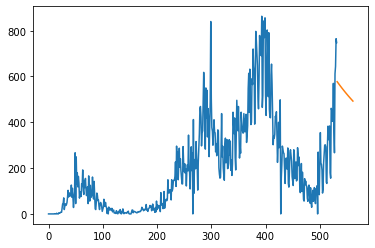

In [31]:
model1_fit = ARIMA(x_log, order=(1, 0, 1)).fit()

plt.plot(range(len(x)),x)
z = range(len(x), len(x) + len(model1_fit.forecast(30)))
plt.plot(z,np.exp (model1_fit.forecast(30)) -10 - x_min)
plt.plot()

print('AIC=', model1_fit.aic)

коэффициент Акаике значительно меньше, значит, точность повысилась

**подбор оптимальных параметров модели**

начальный ряд

In [32]:
df_p=[]
df_d=[]
df_q=[]
df_aic=[]

for p in range(10):
    for d in [0,1,2]:
        for q in range(10):
            try:
                model_fit = ARIMA(df_Fin, order=(p,d,q)).fit()
                model_fit.aic
                
                df_p.append(p)
                df_d.append(d)
                df_q.append(q)
                df_aic.append(model_fit.aic)
            except:
                pass          
df_res = pd.DataFrame({'p':df_p, 'd':df_d, 'q':df_q,'aic':df_aic})
df_res          

,p,d,q,aic
0,0,0,0,7136.496271
1,0,0,1,6751.664286
2,0,0,2,6565.775629
3,0,0,3,6505.772180
4,0,0,4,6414.674718
...,...,...,...,...
295,9,2,5,6020.613971
296,9,2,6,6018.947363
297,9,2,7,6003.000993
298,9,2,8,5993.543421


In [33]:
df_m = df_res[df_res['aic']==df_res['aic'].min()]
df_m

,p,d,q,aic
268,8,2,8,5992.069347


AIC= 5992.069347367424


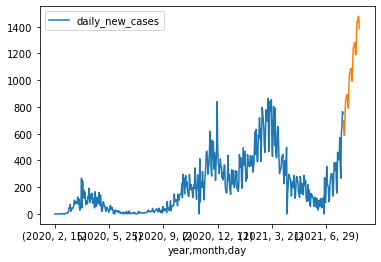

In [34]:
model_fit = ARIMA(df_Fin, order=(8, 2, 8)).fit()
df_Fin.plot()
model_fit.forecast(30).plot()
print('AIC=', model_fit.aic)

странный результат; как будто модель учла только последнюю часть данных, где идёт рост, и построила прогноз по ней; с неоптимальными параметрами было больше похоже на правду

прологарифмированный ряд

In [35]:
df_p1=[]
df_d1=[]
df_q1=[]
df_aic1=[]

x = df_Fin.daily_new_cases.values
x_min = abs(min(x))
x_log = np.log(x+x_min+10)

for p1 in range(10):
    for d1 in [0,1,2]:
        for q1 in range(10):
            try:
                model1_fit = ARIMA(x_log, order=(p1,d1,q1)).fit()
                model1_fit.aic
                
                df_p1.append(p1)
                df_d1.append(d1)
                df_q1.append(q1)
                df_aic1.append(model1_fit.aic)
            except:
                pass          
df_res1 = pd.DataFrame({'p':df_p1, 'd':df_d1, 'q':df_q1,'aic':df_aic1})
df_res1 

,p,d,q,aic
0,0,0,0,1747.803100
1,0,0,1,1383.348424
2,0,0,2,1175.795802
3,0,0,3,1071.286322
4,0,0,4,970.494378
...,...,...,...,...
295,9,2,5,623.586844
296,9,2,6,624.809675
297,9,2,7,606.862259
298,9,2,8,584.222023


In [36]:
df_m1 = df_res1[df_res1['aic']==df_res1['aic'].min()]
df_m1

,p,d,q,aic
229,7,1,9,566.22954


AIC= 566.2295400092822


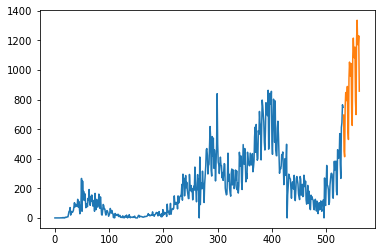

In [41]:
model1_fit = ARIMA(x_log, order=(7, 1, 9)).fit()
plt.plot(range(len(x)),x)
z = range(len(x), len(x) + len(model1_fit.forecast(30)))
plt.plot(z,np.exp (model1_fit.forecast(30)) -10 - x_min)
plt.plot()
print('AIC=', model1_fit.aic)

здесь точность выше, больше похоже на правду, но тоже явно виден общий рост заболеваемости в прогнозе

AIC= 566.2295400092822


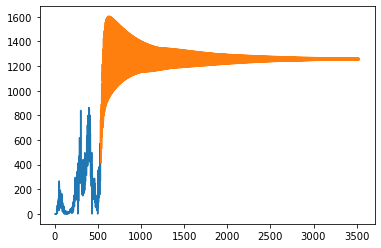

In [42]:
#при прогнозировании на более долгий период, идёт сильный рост, потом небольшой спад и относительная стабилизация на довольно высоком значении
model1_fit = ARIMA(x_log, order=(7, 1, 9)).fit()
plt.plot(range(len(x)),x)
z = range(len(x), len(x) + len(model1_fit.forecast(3000)))
plt.plot(z,np.exp (model1_fit.forecast(3000)) -10 - x_min)
plt.plot()
print('AIC=', model1_fit.aic)

### normal  
##### применить градиентный бустинг для решения задачи
##### используя кросс-валидацию, сравнить результаты ARIMA и бустинга  

разделение на train и test

In [43]:
razdel = int(0.8*len(df_Fin))
y_train, y_test = df_Fin.iloc[:razdel], df_Fin.iloc[razdel:]

**градиентный бустинг, кросс-валидация**

In [44]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [45]:
pred=[]
test=[]

x = df_Fin.values

for i in range (50, len(x)):
    y_train = x[:i]
    x_train = np.arange(len(y_train)).reshape(-1,1)
    test.append(x[i])
   
    model = GradientBoostingRegressor()
    model.fit(x_train, y_train)
    y_pred = model.predict([[i]])
    pred.append(y_pred)

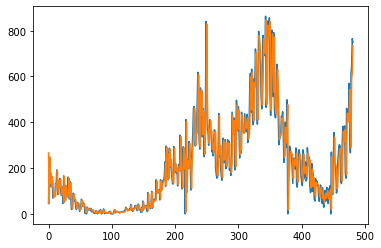

In [46]:
plt.plot(test)
plt.plot(pred)

In [47]:
print('mean_absolute_error',mean_absolute_error(test, pred))
print('mean_squared_error',mean_squared_error(test, pred))
print('r2',r2_score(test, pred))

mean_absolute_error 60.75393998177388
mean_squared_error 8708.368248887133
r2 0.7806539075598351


**ARIMA, кросс-валидация**

In [ ]:
pred_a=[]
test_a=[]

x = df_Fin.values

for i in range (50, len(x)):
    train_a = x[:i]
    test_a.append(x[i])
   
    model_a_fit = ARIMA(train_a, order=(8,2,8)).fit()
    forecast = model_a_fit.forecast(1)[0]
    pred_a.append(forecast) 

In [ ]:
plt.plot(test_a)
plt.plot(pred_a)

In [ ]:
print('mean_absolute_error',mean_absolute_error(test_a, pred_a))
print('mean_squared_error',mean_squared_error(test_a, pred_a))
print('r2', r2_score(test_a, pred_a))

**у ARIMA результат лучше**